In [4]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from pytorch_lightning import LightningModule, Trainer

from opt import get_opts
from losses import NeRFLoss

from torchmetrics import (
    PeakSignalNoiseRatio, 
    StructuralSimilarityIndexMeasure
)

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

c:\Users\willi\anaconda3\envs\william\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [ ]:
class NeRFSystem(LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)

        self.warmup_steps = 256
        self.update_interval = 16

        self.loss = NeRFLoss(lambda_distortion=self.hparams.distortion_loss_w)
        self.train_psnr = PeakSignalNoiseRatio(data_range=1)
        self.val_psnr = PeakSignalNoiseRatio(data_range=1)
        self.val_ssim = StructuralSimilarityIndexMeasure(data_range=1)
        if self.hparams.eval_lpips:
            self.val_lpips = LearnedPerceptualImagePatchSimilarity('vgg')
            for p in self.val_lpips.net.parameters():
                p.requires_grad = False

        rgb_act = 'None' if self.hparams.use_exposure else 'Sigmoid' 
        self.model = NGP(scale=self.hparams.scale, rgb_act=rgb_act)
        G = self.model.grid_size
        self.model.register_buffer('density_grid',
            torch.zeros(self.model.cascades, G**3))
        self.model.register_buffer('grid_coords',
            create_meshgrid3d(G, G, G, False, dtype=torch.int32).reshape(-1, 3))


In [2]:
if __name__ == '__main__':
    hparams = get_opts()    # get hyperparameters from command line arguments (opt.py/get_opts())
    if hparams.val_only and (not hparams.ckpt_path):
        raise ValueError('You need to provide a @ckpt_path for validation!')
    system = NeRFSystem(hparams)


usage: ipykernel_launcher.py [-h] --root_dir ROOT_DIR
                             [--dataset_name {nerf,nsvf,colmap,nerfpp,rtmv}]
                             [--split {train,trainval,trainvaltest}]
                             [--downsample DOWNSAMPLE] [--scale SCALE]
                             [--use_exposure]
                             [--distortion_loss_w DISTORTION_LOSS_W]
                             [--batch_size BATCH_SIZE]
                             [--ray_sampling_strategy {all_images,same_image}]
                             [--num_epochs NUM_EPOCHS] [--num_gpus NUM_GPUS]
                             [--lr LR] [--optimize_ext] [--random_bg]
                             [--eval_lpips] [--val_only] [--no_save_test]
                             [--exp_name EXP_NAME] [--ckpt_path CKPT_PATH]
                             [--weight_path WEIGHT_PATH]
ipykernel_launcher.py: error: the following arguments are required: --root_dir


SystemExit: 2

c:\Users\willi\anaconda3\envs\william\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
model = torch.load('model_nerf').to(device)

In [5]:
def mse2psnr(mse): 
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [6]:
img, mse, psnr = test(model, torch.from_numpy(test_o[0]).to(device).float(), torch.from_numpy(test_d[0]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[0].reshape(400, 400, 3))

print(psnr)

28.8992808286121


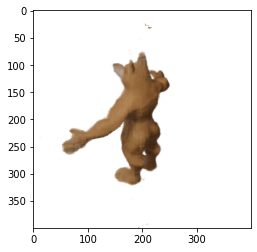

In [7]:
plt.imshow(img)